    id                   name        years                         genre  \
8    8       Vincent van Gogh  1853 – 1890            Post-Impressionism   
30  30            Edgar Degas  1834 - 1917                 Impressionism   
13  13          Pablo Picasso  1881 - 1973                        Cubism   
15  15  Pierre-Auguste Renoir  1841 - 1919                 Impressionism   
19  19         Albrecht Dürer  1471 - 1528          Northern Renaissance   
46  46           Paul Gauguin  1848 – 1903  Symbolism,Post-Impressionism   
16  16         Francisco Goya  1746 - 1828                   Romanticism   
31  31              Rembrandt  1606 - 1669                       Baroque   
20  20          Alfred Sisley  1839 - 1899                 Impressionism   
32  32                 Titian  1488 - 1576    High Renaissance,Mannerism   

       nationality                                                bio  \
8            Dutch  Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...   
30          Frenc

2021-12-17 11:50:41.605472: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 277, 277, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 277, 277, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 277, 277, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 138, 138, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 138, 138, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 138, 138, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 69, 69, 128)       0     

/usr/local/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
2021-12-17 11:50:42.152031: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


812/812 [==============================] - 145s 178ms/step
              precision    recall  f1-score   support

           0       0.88      0.95      0.91        59
           1       0.72      0.96      0.82        53
           2       0.93      0.90      0.92       156
           3       0.69      0.91      0.79        57
           4       0.82      0.89      0.85        89
           5       0.83      0.70      0.76        64
           6       0.97      0.80      0.88        79
           7       0.97      0.77      0.86        48
           8       0.89      0.89      0.89        44
           9       0.90      0.86      0.88       163

    accuracy                           0.86       812
   macro avg       0.86      0.86      0.86       812
weighted avg       0.88      0.86      0.87       812



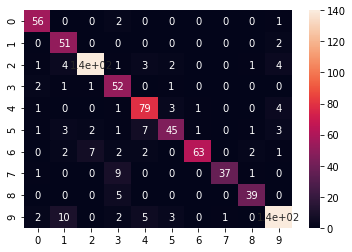

In [1]:
# Import libraries
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as K
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report


NUM_ARTISTS = 10

# get directories
main_direc = os.getcwd()
images_dir = os.path.join(main_direc, 'data/images/images')

# csv location
artist_csv_loc = os.path.join(main_direc, 'data/artists.csv')


# Collecting Needed Images
artists = pd.read_csv(artist_csv_loc)

# Creating a dataframe with the top 10 artists by number of paintings
artists_sort = artists.sort_values(by=['paintings'], ascending=False)

artists_top = artists_sort.head(NUM_ARTISTS) # need to add 1 so 10 classes are read in
print(artists_top)

# Images DataFrame
artists_top_name = artists_top['name'].str.replace(' ', '_').values

images_df = pd.DataFrame()
for name in artists_top_name:
    images_df = pd.concat([images_df, pd.DataFrame(data={'Path': glob.glob('data/images/images/' + name + '/*'), 'Name': name})], ignore_index=True)

print(images_df)

# Create Generator


BATCH_SIZE = 64

# image dimensions?
img_width, img_height = 277, 277

train_df = images_df.sample(frac=0.8, random_state=200)
test_df = images_df.drop(train_df.index)

if K.backend.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

# Train

train_generator = ImageDataGenerator(rescale=1.0 / 255,
                                     rotation_range=20,
                                     zoom_range=0.05,
                                     width_shift_range=0.05,
                                     height_shift_range=0.05,
                                     shear_range=0.05,
                                     horizontal_flip=True,
                                     fill_mode="nearest",
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input

                                     )

test_generator = ImageDataGenerator(rescale=1.0 / 255, preprocessing_function=preprocess_input)

train_gen = train_generator.flow_from_dataframe(
    train_df,
    shuffle=True,
    x_col='Path',
    y_col='Name',
    class_mode='categorical',
    subset="training",
    batch_size=BATCH_SIZE,
    target_size=(img_width, img_height),
    seed=42
)

valid_gen = train_generator.flow_from_dataframe(
    train_df,
    subset="validation",
    shuffle=True,
    x_col='Path',
    y_col='Name',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    target_size=(img_width, img_height),
    seed=42
)

test_gen = test_generator.flow_from_dataframe(
    test_df,
    x_col='Path',
    batch_size=1,
    shuffle=False,
    class_mode=None,
    target_size=(img_width, img_height)
)


def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    conv_base = VGG16(include_top=False,
                      weights='imagenet',
                      input_shape=input_shape)
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(500, activation='relu')(top_model)
    top_model = Dense(100, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    model = Model(inputs=conv_base.input, outputs=output_layer)

    model.compile(optimizer=optimizer,
                  loss=tf.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    return model

#step sizes:
steps_train = train_gen.n//train_gen.batch_size
steps_valid = valid_gen.n//valid_gen.batch_size
steps_test = test_gen.n//test_gen.batch_size


optimizer = tf.optimizers.Adam(learning_rate=0.001)
n_classes = 10
n_epochs = 50

vgg = create_model(input_shape,n_classes, optimizer, fine_tune=0)

#loss_plot
#v1_loss_plot = PlotLossesCallback()

#model checkpoint

v1_checkpoint = ModelCheckpoint(filepath='v1_best_weights.hdf5',
                               save_best_only = True,
                               verbose = 1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

vgg.summary()

# Generate predictions
vgg.load_weights('v1_best_weights.hdf5') # initialize the best trained weights
# make predictions using the test set
predict = vgg.predict_generator(test_gen, steps=steps_test, verbose=1)

# collect the actual index of the predicted class
predicted_class = np.argmax(predict, axis=1)

# collect the actual classes of the predictions
r = dict(train_gen.class_indices.items())
y_true = test_df['Name']
y_true = [r[k] for k in y_true]

# create confusion matrix
cm = confusion_matrix(y_true, predicted_class)
fig = sns.heatmap(cm, annot=True)

# print classification report
print(classification_report(y_true, predicted_class))